Freeman Chain Code: [3, 3, 3, 4, 5, 3, 4, 3, 2, 3, 2, 4, 5, 4, 5, 3, 5, 6, 4, 5, 5, 3, 5, 3, 3, 4, 3, 3, 4, 4, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 4, 1, 2, 3, 3, 2, 3, 4, 6, 7, 5, 4, 4, 5, 5, 2, 3, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 5, 3, 4, 5, 6, 4, 5, 3, 2, 3, 3, 4, 2, 3, 2, 3, 2, 4, 5, 4, 5, 3, 5, 5, 5, 3, 5, 4, 3, 4, 3, 4, 3, 4, 4, 5, 4, 3, 4, 5, 6, 0, 1, 2, 4, 3, 4, 3, 4, 0, 3, 4, 1, 3, 3, 5, 2, 3, 1, 2, 2, 2, 4, 3, 2, 3, 2, 3, 3, 4, 2, 3, 3, 3, 2, 2, 1, 2, 0, 1, 0, 2, 1, 3, 4, 3, 3, 4, 3, 3, 2, 3, 5, 3, 3, 4, 3, 5, 4, 4, 5, 3, 5, 4, 5, 5, 5, 5, 3, 4, 2, 3, 1, 1, 1, 0, 1, 2, 1, 3, 1, 0, 1, 2, 3, 1, 2, 1, 2, 7, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 1, 2, 1, 3, 3, 3, 3, 2, 2, 1, 1, 3, 3, 1, 3, 3, 2, 1, 3, 1, 2, 1, 0, 1, 3, 0, 0, 1, 0, 2, 1, 3, 1, 3, 3, 4, 1, 2, 3, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 2, 3, 2, 3, 0, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 4, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 1, 3, 1, 3, 1, 1, 2, 1, 2, 0, 1, 2, 1, 2, 2, 1

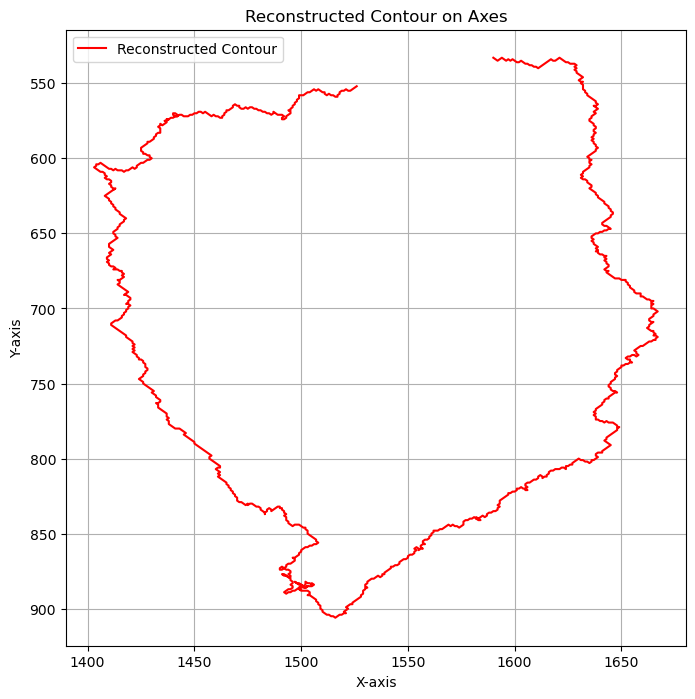

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def freeman_chain_code(contour):
    # 定义Freeman编码的方向
    directions = [0, 1, 2, 3, 4, 5, 6, 7]
    dx = [1, 1, 0, -1, -1, -1, 0, 1]
    dy = [0, 1, 1, 1, 0, -1, -1, -1]
    chain_code = []
    for i in range(len(contour) - 1):
        current_point = contour[i][0]
        next_point = contour[i + 1][0]
        dx_val = next_point[0] - current_point[0]
        dy_val = next_point[1] - current_point[1]
        for j in range(8):
            if dx[j] == dx_val and dy[j] == dy_val:
                chain_code.append(directions[j])
                break
    return chain_code

# 读取图像
image = cv2.imread(r"C:\Users\28489\Desktop\paired\12\2.jpg", 0)
# 图像预处理：高斯模糊减少噪声
blurred = cv2.GaussianBlur(image, (5, 5), 0)
# 进行边缘检测，调整Canny阈值
edges = cv2.Canny(blurred, 30, 100)
# 形态学操作：膨胀操作连接边缘
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=1)
# 查找轮廓
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 假设最大的轮廓是残片的轮廓
largest_contour = max(contours, key=cv2.contourArea)
# 绘制轮廓
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)
# 计算Freeman编码
chain_code = freeman_chain_code(largest_contour)

# 显示轮廓图像
cv2.imshow('Contour', contour_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 打印Freeman编码
print("Freeman Chain Code:", chain_code)

# 定义Freeman编码的方向
dx = [1, 1, 0, -1, -1, -1, 0, 1]
dy = [0, 1, 1, 1, 0, -1, -1, -1]

# 初始化起始点
start_point = largest_contour[0][0]
reconstructed_contour = [start_point]
current_point = start_point

# 根据Freeman编码还原轮廓
for code in chain_code:
    next_point = (current_point[0] + dx[code], current_point[1] + dy[code])
    # 确保还原的点在图像范围内
    next_point = (
        max(0, min(next_point[0], image.shape[1] - 1)),
        max(0, min(next_point[1], image.shape[0] - 1))
    )
    reconstructed_contour.append(next_point)
    current_point = next_point

# 将重建的轮廓转换为numpy数组
reconstructed_contour = np.array(reconstructed_contour, dtype=np.int32)
reconstructed_contour = reconstructed_contour.reshape((-1, 1, 2))

# 绘制重建的轮廓
reconstructed_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(reconstructed_image, [reconstructed_contour], -1, (0, 0, 255), 2)

# 显示重建的轮廓
cv2.imshow('Reconstructed Contour', reconstructed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 提取重建轮廓的x和y坐标
x = reconstructed_contour[:, 0, 0]
y = reconstructed_contour[:, 0, 1]

# 打印在坐标轴上
plt.figure(figsize=(8, 8))
plt.plot(x, y, 'r-', label='Reconstructed Contour')
plt.title('Reconstructed Contour on Axes')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()  # 反转y轴以匹配图像坐标系
plt.show()
